# Results wPCC VCT

In [21]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys, plot_VCT_components

import paper
from phd.visualization.styles import styles
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from sklearn.metrics import mean_squared_error, r2_score
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
import matplotlib.patches as mpatches 
from phd.visualization.circle_drift import plot_3d_circle_drift, predict_circle_drift_matrix, plot_3d_circle_drift_matplotlib

In [23]:
ship_name = "wPCC"

In [24]:
#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder").items()}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']
loaders.pop('polynomial rudder complex')  # for now...

[02/24/25 15:40:05] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder'              ]8;id=33350;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915508;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT' (PartitionedDataset)...        ]8;id=726370;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=719825;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<bound method AbstractDataset.load of <phd.extras.datasets.model_dataset.ModularVesselSimulatorDataSet object at 0x7f8b42ec5f00>>

In [25]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [26]:
#model = models['polynomial rudder simple']

In [27]:
#df_VCT = catalog.load(f"{ship_name}.df_VCT_all_raw")['M5139-02-A_MS.df_VCT']()
#(df_VCT['fx'] - df_VCT['fx_rudders'] - df_VCT['fx_hull'] - model.parameters['Xthrustport']*df_VCT['thrust'])

In [28]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")

[02/24/25 15:40:12] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=907783;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=425016;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [29]:
assert ((df_VCT['Y_D'] - df_VCT['Y_R'] - df_VCT['Y_H']).abs() < 10**-10).all()
assert ((df_VCT['N_D'] - df_VCT['N_R'] - df_VCT['N_H']).abs() < 10**-10).all()
assert ((df_VCT['X_D'] - df_VCT['X_R'] - df_VCT['X_P'] - df_VCT['X_H']).abs() < 10**-10).all()

In [30]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
mask = df_VCT['V'] > 0.9
df_VCT = df_VCT.loc[mask].copy()
df_VCT = add_mirrored(df_VCT)
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=654574;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=90466;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [31]:
df_prediction = predict(model=model, data=df_VCT)
df_prediction['Y_H']+=df_prediction['Y_RHI']
df_prediction['N_H']+=df_prediction['N_RHI']



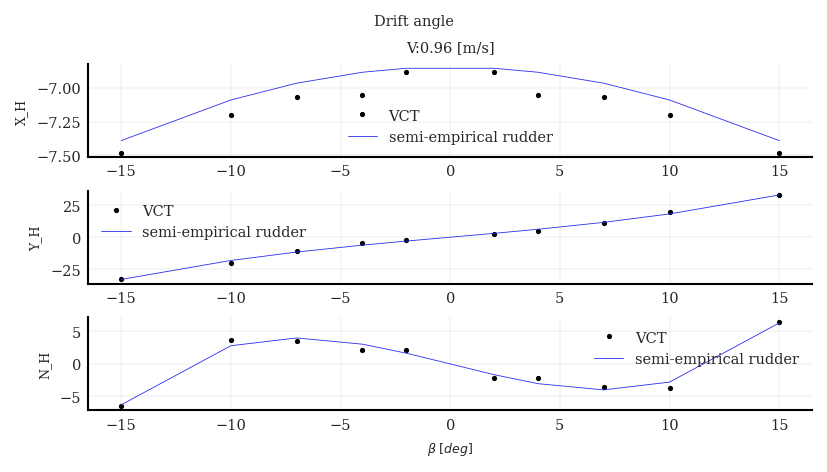

In [32]:
predictions = {
    "semiempirical rudder" : df_prediction,
}

plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys = ['X_H', 'Y_H', 'N_H'], test_type='Drift angle', styles=styles);

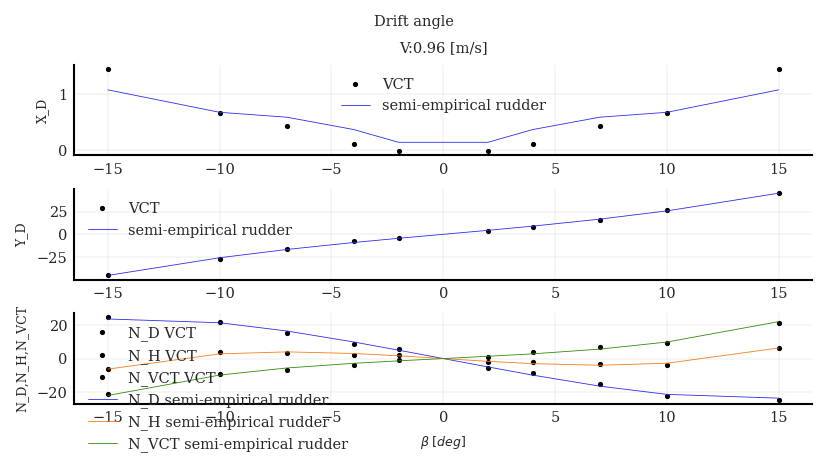

In [33]:
plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys=['X_D', 'Y_D', ['N_D','N_H','N_VCT']], test_type='Drift angle', styles=styles);

In [34]:
#df_VCT['X_P'] = df_VCT['thrust']

In [35]:
#df_prediction['X_H']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [36]:
#df_prediction['X_D']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [37]:
model.subsystems['hull'].equations['X_H']

Eq(X_H, X_{0} + X_{rr}*r**2 + X_{u}*u + X_{vr}*r*v + X_{vv}*v**2)

In [38]:
color_palette = ['k','c','r','m']
colors={}
for dof in ['X','Y','N']:
    color_all = color_palette.copy()
    for subscript in ['D','H','R','P']:
        key = f"{dof}_{subscript}"
        colors[key] = color_all.pop(0)
        

In [39]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

[02/24/25 15:40:14] WARNING  /tmp/ipykernel_21994/249674081.py:35: MatplotlibDeprecationWarning: An ]8;id=137035;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=449368;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             artist whose label starts with an underscore was passed to legend();                  
                             such artists will no longer be ignored in the future.  To suppress                    
                             this warning, explicitly filter out such artists, e.g. with `[art for                 
                             art in artists if not art.get_label().startswith('_')]`.                              
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.5, 1.62), ncol=3)                                                   
                                                                                                                   

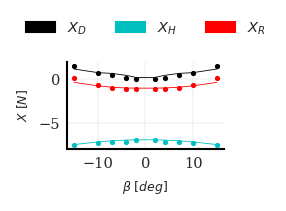

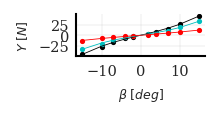

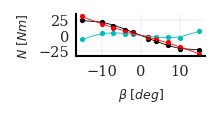

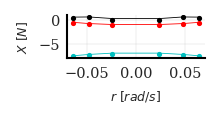

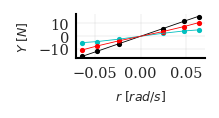

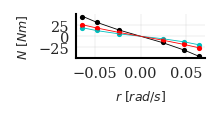

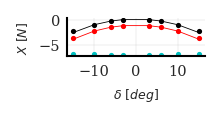

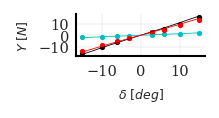

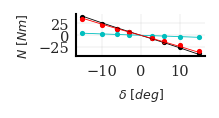

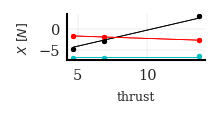

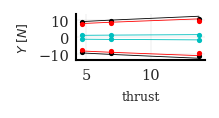

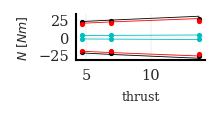

In [40]:

dofs={
    'X':{
        'y_label':r'$X$ $[N]$',
        'y_keys':['X_D','X_H','X_R'],
    },
    'Y':{
        'y_label':r'$Y$ $[N]$',
        'y_keys':['Y_D','Y_H','Y_R'],
    },
    'N':{
        'y_label':r'$N$ $[Nm]$',
        'y_keys':['N_D','N_H','N_R'],
    },
    
}

test_types = [
    'Drift angle',
    'Circle',
    'Rudder angle',
    'Thrust variation',
             ]

first = True
for test_type in test_types:
    for dof, meta_data in dofs.items():
    
        fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[meta_data['y_keys'],], test_type=test_type, 
                            colors=colors);

        if first:
            labels = [line.get_label() for line in fig.axes[0].lines]
            colors_ = [line.get_color() for line in fig.axes[0].lines]
            patches = [mpatches.Patch(color=colors_[i], label=label) for i,label in enumerate(labels)]
            fig.axes[0].legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.62), ncol=3)
            first = False
            #fig.tight_layout()
        else:
            fig.axes[0].get_legend().set_visible(False)
        
        fig.axes[0].set_ylabel(meta_data['y_label'])
        fig.set_size_inches(paper.figure_width/4, paper.figure_height/4)
        fig.suptitle('')
        fig.axes[0].set_title('')
        test_name = test_type.lower().replace(' ','_')
        file_name = f"{test_name}_{dof}"
        paper.save_fig(fig,f"{file_name}.svg")

In [41]:
paper.figure_width/4

1.3493725

In [42]:
#mask = ((df_VCT['delta'] == 0))
#df = df_VCT.loc[mask]
df = df_VCT.groupby('test type').get_group('Circle + Drift')
df = df.groupby('r').filter(lambda x:len(x) > 1)

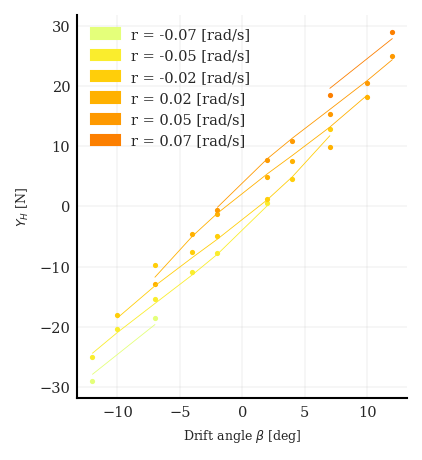

In [43]:
fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['Y_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]

fig.axes[0].legend(labels, handles=patches)
fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$Y_H$ [N]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_Y_H.svg")

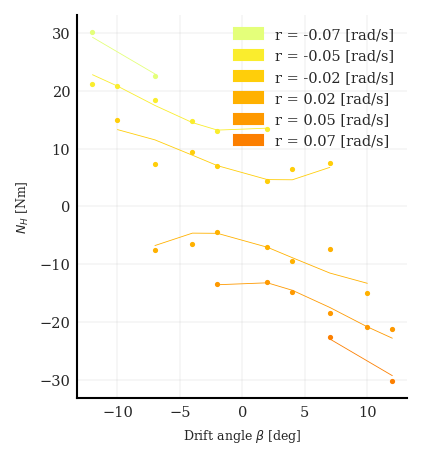

In [44]:

fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['N_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]
fig.axes[0].legend(labels, handles=patches)

fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$N_H$ [Nm]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_N_H.svg")

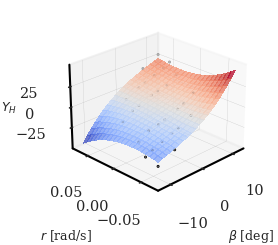

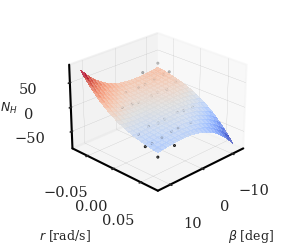

In [45]:
azim=225
fig = plot_3d_circle_drift_matplotlib(df=df, model=model, key='Y_H', azim=azim);
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,'Y_H.svg')

fig = plot_3d_circle_drift_matplotlib(df=df, model=model, key='N_H', azim=45);
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,'N_H.svg')


In [46]:
model2 = model.copy()

In [47]:
model2.parameters['Yvrr'] = 0
model2.parameters['Yvvr'] = 0
model2.parameters['Nvvr'] = 0
model2.parameters['Nvrr'] = 0

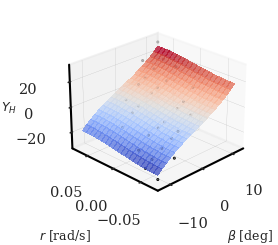

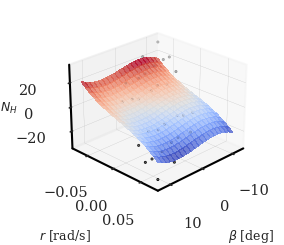

In [48]:
azim=225
fig = plot_3d_circle_drift_matplotlib(df=df, model=model2, key='Y_H', azim=azim);
fig.set_size_inches(paper.figure_width/3,paper.figure_height/2)
paper.save_fig(fig,'Y_H_no_coupling.svg')

fig = plot_3d_circle_drift_matplotlib(df=df, model=model2, key='N_H', azim=45);
fig.set_size_inches(paper.figure_width/3,paper.figure_height/2)
paper.save_fig(fig,'N_H_no_coupling.svg')